RSA teszt...

Kyber teszt...

ECC teszt...

Átlagolt eredmények:
RSA:
 - Kulcsgenerálási idő: 0.870702 másodperc
 - Titkosítási idő: 0.000608 másodperc
 - Visszafejtési idő: 0.003085 másodperc
 - Memóriahasználat: 256.00 KB
Kyber:
 - Kulcsgenerálási idő: 0.007880 másodperc
 - Titkosítási idő: 0.010933 másodperc
 - Visszafejtési idő: 0.015032 másodperc
 - Memóriahasználat: 64.00 KB
ECC:
 - Kulcsgenerálási idő: 0.022456 másodperc
 - Titkosítási idő: 0.022304 másodperc
 - Visszafejtési idő: 0.022413 másodperc
 - Memóriahasználat: 64.00 KB


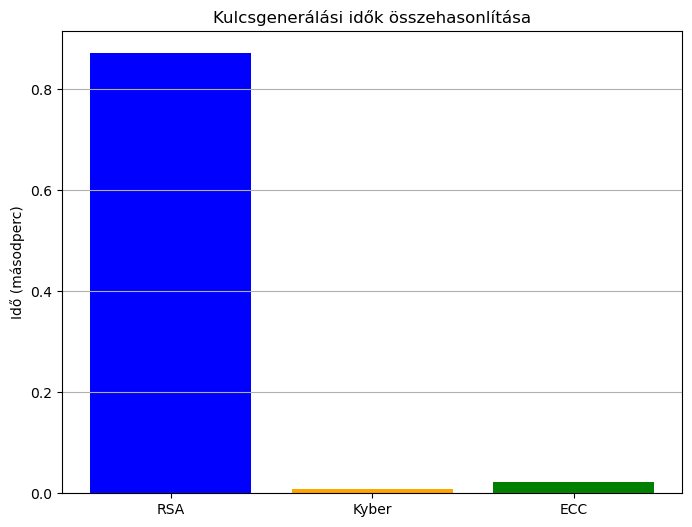

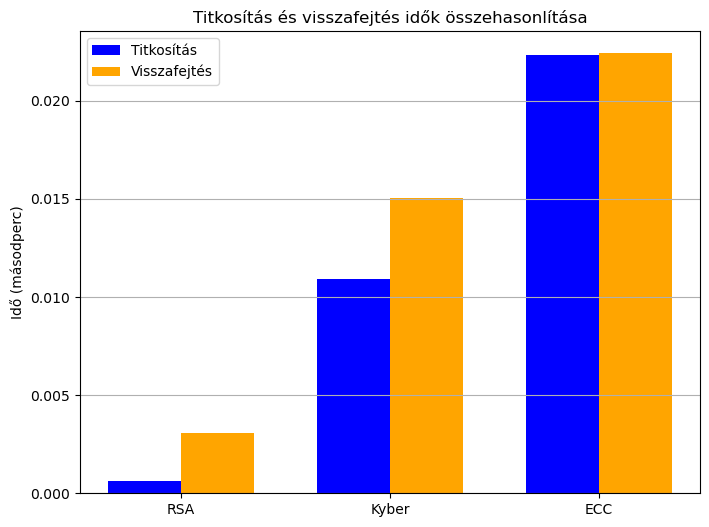

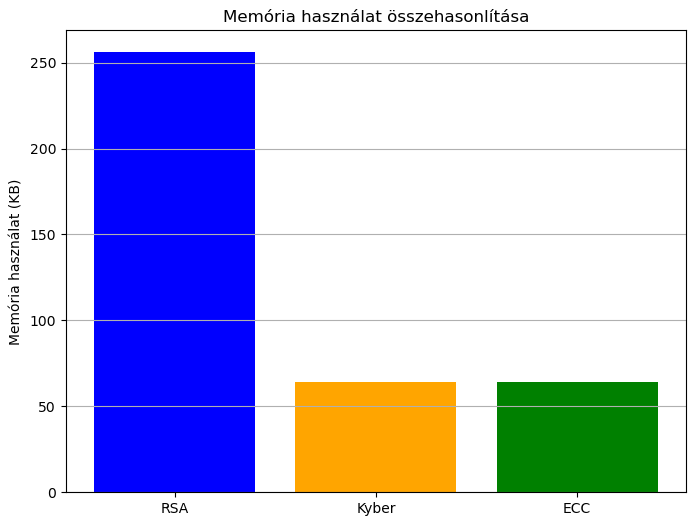

In [79]:
# !pip install tinyec 
# !pip install pycrytodome 
#  https://github.com/asdfjkl/pyky   
# !pip install matplotlib

import os
import time
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from ccakem import kem_keygen512, kem_encaps512, kem_decaps512
from tinyec import registry
import secrets

# RSA teszt
def rsa_encryption_test(repeats=100):
    enc_times, dec_times, keygen_times = [], [], []
    mem_usage = []

    for _ in range(repeats):
        start_time = time.time()
        rsa_key = RSA.generate(2048)
        end_time = time.time()
        keygen_times.append(end_time - start_time)
        rsa_pub_key = rsa_key.publickey()

        aes_key = os.urandom(32)
        cipher = PKCS1_OAEP.new(rsa_pub_key)
        start_time = time.time()
        rsa_ciphertext = cipher.encrypt(aes_key)
        end_time = time.time()
        enc_times.append(end_time - start_time)

        cipher = PKCS1_OAEP.new(rsa_key)
        start_time = time.time()
        rsa_plaintext = cipher.decrypt(rsa_ciphertext)
        end_time = time.time()
        dec_times.append(end_time - start_time)

        assert aes_key == rsa_plaintext, "RSA visszafejtett kulcs nem egyezik!"
        mem_usage.append((2048 // 8) + len(rsa_ciphertext) // 1024)

    return {
        "keygen_time": sum(keygen_times) / repeats,
        "enc_time": sum(enc_times) / repeats,
        "dec_time": sum(dec_times) / repeats,
        "mem_usage": sum(mem_usage) / repeats,
    }


# Kyber teszt
def kyber_encryption_test(repeats=100):
    enc_times, dec_times, keygen_times = [], [], []
    mem_usage = []

    for _ in range(repeats):
        start_time = time.time()
        priv_key, pub_key = kem_keygen512()
        end_time = time.time()
        keygen_times.append(end_time - start_time)

        start_time = time.time()
        shared_secret_enc, ciphertext = kem_encaps512(pub_key)
        end_time = time.time()
        enc_times.append(end_time - start_time)

        start_time = time.time()
        shared_secret_dec = kem_decaps512(priv_key, ciphertext)
        end_time = time.time()
        dec_times.append(end_time - start_time)

        assert shared_secret_enc == shared_secret_dec, "Kyber visszafejtett kulcs nem egyezik!"
        mem_usage.append((512 // 8) + len(ciphertext) // 1024)

    return {
        "keygen_time": sum(keygen_times) / repeats,
        "enc_time": sum(enc_times) / repeats,
        "dec_time": sum(dec_times) / repeats,
        "mem_usage": sum(mem_usage) / repeats,
    }


# ECC teszt `tinyec`-kel
def ecc_tinyec_test(repeats=100):
    enc_times, dec_times, keygen_times = [], [], []
    mem_usage = []

    curve = registry.get_curve('secp256r1')

    for _ in range(repeats):
        start_time = time.time()
        priv_key = secrets.randbelow(curve.field.n)
        pub_key = priv_key * curve.g
        end_time = time.time()
        keygen_times.append(end_time - start_time)

        other_priv_key = secrets.randbelow(curve.field.n)
        other_pub_key = other_priv_key * curve.g

        start_time = time.time()
        shared_key = priv_key * other_pub_key
        end_time = time.time()
        enc_times.append(end_time - start_time)

        start_time = time.time()
        shared_key_dec = other_priv_key * pub_key
        end_time = time.time()
        dec_times.append(end_time - start_time)

        assert shared_key == shared_key_dec, "ECC visszafejtett kulcs nem egyezik!"
        mem_usage.append((256 // 8) + (256 // 8))

    return {
        "keygen_time": sum(keygen_times) / repeats,
        "enc_time": sum(enc_times) / repeats,
        "dec_time": sum(dec_times) / repeats,
        "mem_usage": sum(mem_usage) / repeats,
    }


# Tesztelés
print("RSA teszt...")
rsa_results = rsa_encryption_test(repeats=100)

print("\nKyber teszt...")
kyber_results = kyber_encryption_test(repeats=100)

print("\nECC teszt...")
ecc_results = ecc_tinyec_test(repeats=100)

# Eredmények
algorithms = ['RSA', 'Kyber', 'ECC']
keygen_times = [rsa_results['keygen_time'], kyber_results['keygen_time'], ecc_results['keygen_time']]
enc_times = [rsa_results['enc_time'], kyber_results['enc_time'], ecc_results['enc_time']]
dec_times = [rsa_results['dec_time'], kyber_results['dec_time'], ecc_results['dec_time']]
mem_usages = [rsa_results['mem_usage'], kyber_results['mem_usage'], ecc_results['mem_usage']]

# Szöveges eredmények kiírása
print("\nÁtlagolt eredmények:")
for alg, ktime, etime, dtime, mem in zip(algorithms, keygen_times, enc_times, dec_times, mem_usages):
    print(f"{alg}:")
    print(f" - Kulcsgenerálási idő: {ktime:.6f} másodperc")
    print(f" - Titkosítási idő: {etime:.6f} másodperc")
    print(f" - Visszafejtési idő: {dtime:.6f} másodperc")
    print(f" - Memóriahasználat: {mem:.2f} KB")

# Diagram 1: Kulcsgenerálás ideje
plt.figure(figsize=(8, 6))
plt.bar(algorithms, keygen_times, color=['blue', 'orange', 'green'])
plt.ylabel('Idő (másodperc)')
plt.title('Kulcsgenerálási idők összehasonlítása')
plt.grid(axis='y')
plt.show()

# Diagram 2: Titkosítási és visszafejtési idők
x = range(len(algorithms))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, enc_times, width, label='Titkosítás', color='blue')
plt.bar([p + width for p in x], dec_times, width, label='Visszafejtés', color='orange')
plt.xticks([p + width / 2 for p in x], algorithms)
plt.ylabel('Idő (másodperc)')
plt.title('Titkosítás és visszafejtés idők összehasonlítása')
plt.legend()
plt.grid(axis='y')
plt.show()

# Diagram 3: Memória használat (kb)
plt.figure(figsize=(8, 6))
plt.bar(algorithms, mem_usages, color=['blue', 'orange', 'green'])
plt.ylabel('Memória használat (KB)')
plt.title('Memória használat összehasonlítása')
plt.grid(axis='y')
plt.show()



RSA Benchmark...
Kyber Benchmark...
ECC Benchmark...

Benchmark eredmények (10 ms alatt végrehajtott iterációk száma):
 - RSA: 14 iteráció
 - Kyber: 291 iteráció
 - ECC : 114 iteráció


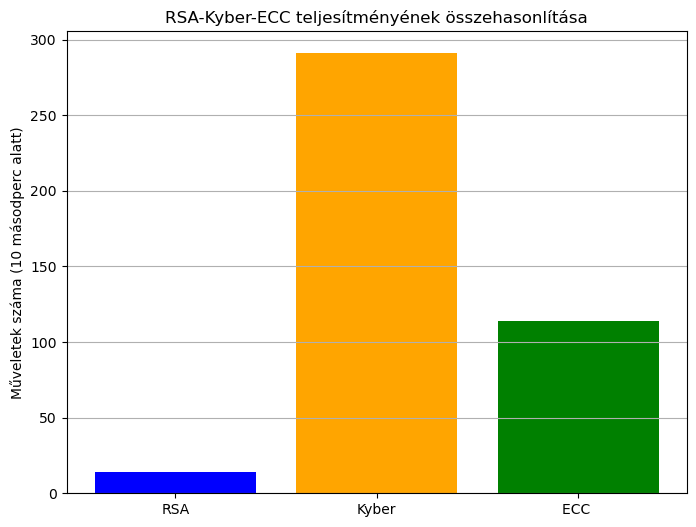

In [3]:
import os
import time
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from ccakem import kem_keygen512, kem_encaps512, kem_decaps512
from tinyec import registry
import secrets


# RSA Benchmark
def rsa_benchmark(duration=10):
    count = 0
    start_time = time.time()
    while time.time() - start_time < duration:
        rsa_key = RSA.generate(2048)
        rsa_pub_key = rsa_key.publickey()

        aes_key = os.urandom(32)
        cipher = PKCS1_OAEP.new(rsa_pub_key)
        rsa_ciphertext = cipher.encrypt(aes_key)

        cipher = PKCS1_OAEP.new(rsa_key)
        rsa_plaintext = cipher.decrypt(rsa_ciphertext)

        assert aes_key == rsa_plaintext, "RSA visszafejtett kulcs nem egyezik!"
        count += 1
    return count


# Kyber Benchmark
def kyber_benchmark(duration=10):
    count = 0
    start_time = time.time()
    while time.time() - start_time < duration:
        priv_key, pub_key = kem_keygen512()
        shared_secret_enc, ciphertext = kem_encaps512(pub_key)
        shared_secret_dec = kem_decaps512(priv_key, ciphertext)

        assert shared_secret_enc == shared_secret_dec, "Kyber visszafejtett kulcs nem egyezik!"
        count += 1
    return count


# ECC Benchmark `tinyec` használatával
def ecc_benchmark_tinyec(duration=10):
    count = 0
    start_time = time.time()
    curve = registry.get_curve('secp256r1')

    while time.time() - start_time < duration:
        priv_key = secrets.randbelow(curve.field.n)
        pub_key = priv_key * curve.g

        other_priv_key = secrets.randbelow(curve.field.n)
        other_pub_key = other_priv_key * curve.g

        shared_key = priv_key * other_pub_key
        shared_key_dec = other_priv_key * pub_key

        assert shared_key == shared_key_dec, "ECC visszafejtett kulcs nem egyezik!"
        count += 1
    return count


# Benchmark Tesztelés
print("RSA Benchmark...")
rsa_count = rsa_benchmark()

print("Kyber Benchmark...")
kyber_count = kyber_benchmark()

print("ECC Benchmark...")
ecc_count = ecc_benchmark_tinyec()

# Eredmények
algorithms = ['RSA', 'Kyber', 'ECC ']
benchmark_counts = [rsa_count, kyber_count, ecc_count]

print("\nBenchmark eredmények (10 ms alatt végrehajtott iterációk száma):")
for alg, count in zip(algorithms, benchmark_counts):
    print(f" - {alg}: {count} iteráció")

# Diagram: Benchmark eredmények
plt.figure(figsize=(8, 6))
plt.bar(algorithms, benchmark_counts, color=['blue', 'orange', 'green'])
plt.ylabel('Műveletek száma (10 másodperc alatt)')
plt.title('RSA-Kyber-ECC teljesítményének összehasonlítása')
plt.grid(axis='y')
plt.show()
